# An Applied Study on Zero-Tillage and Water-holding Capacity in Spain, Python Scripts
### Tara Greig
#### Too Big To Excel, Spring 2022
#### Dr. Joshua Rhodes
#### 6 May 2022

**_______**

__Necessary packages and modules:__

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
import os
import glob
from raster2xyz.raster2xyz import Raster2xyz # might have to install via pip
import rioxarray as rxr 
from shapely.geometry import mapping
from urllib.request import urlopen
import contextily as cx
import gdal


__Load datasets (using relative pathing), assign statistics, and extract data of interest__

*ignore warnings at the bottom (as of 5/3/2022)


In [2]:
# load Spanish autonomous regions and agriculture datasets
spain_gdf = gpd.read_file("Spain_shp/ESP_adm2.shp")
spain_till = pd.read_excel('ef_mp_prac_page_spreadsheet.xlsx', sheet_name='Sheet 1',skiprows=11)
spain_organic = pd.read_excel('ef_lus_main__custom_2266741_page_spreadsheet.xlsx', sheet_name='Sheet 1',skiprows=11)
spain_cereal = pd.read_excel('ef_lus_main__custom_2266753_page_spreadsheet.xlsx', sheet_name='Sheet 1',skiprows=11)


# read in global whc data, get shape representation
# read in country data and get bounds for spain only
countries_gdf = gpd.read_file("IPUMSI_world_release2020/world_countries_2020.shp")
spain_only = countries_gdf[countries_gdf['CNTRY_NAME'] == 'Spain']
# clip to spain only, save new raster
soil_whc = rxr.open_rasterio("whc-tif-raster/whc.tif",masked=True).squeeze()
whc_clipped = soil_whc.rio.clip(spain_only.geometry.apply(mapping))
whc_clipped.rio.to_raster('whc-tif-raster/clipped-whc.tif')
# convert global and clipped raster to point data
rtxyz = Raster2xyz()
rtxyz.translate('whc-tif-raster/whc.tif', 'whc-tif-raster/whc_xyz.csv')
rtxyz.translate('whc-tif-raster/clipped-whc.tif', 'whc-tif-raster/clipped_xyz.csv')
# load global and clipped point data
whc_xyz = pd.read_csv('whc-tif-raster/whc_xyz.csv')
whc_spain_xy = pd.read_csv('whc-tif-raster/clipped_xyz.csv')
# merge clipped point data with original point data to eliminate r2xyz bug distortions
whc_spain_xyz = whc_xyz.merge(whc_spain_xy, on=['x','y'],how='inner')
del whc_spain_xyz['z_y']


# load bulk density data and convert to common crs
soil_bd = rxr.open_rasterio("STU_EU_Layers/STU_EU_T_BD.rst",masked=True).squeeze()
rtxyz = Raster2xyz()
rtxyz.translate('STU_EU_Layers/STU_EU_T_BD.rst', 'STU_EU_Layers/STU_EU_T_BD-xyz.csv')
bd_spain_xyz = pd.read_csv('STU_EU_Layers/STU_EU_T_BD-xyz.csv')
bd_spain_xyz = bd_spain_xyz[(bd_spain_xyz['x'] > 1546543) & (bd_spain_xyz['x'] < 3833733) & (bd_spain_xyz['y'] > 941292.065306) & (bd_spain_xyz['y'] < 2468076)]
bd_spain_gdf = gpd.GeoDataFrame(bd_spain_xyz,crs=3035,geometry=gpd.points_from_xy(bd_spain_xyz.x,bd_spain_xyz.y))
bd_spain_gdf = bd_spain_gdf.to_crs(epsg=3857)


# zero-tillage whc enhacement factor
zt_fac = 1.1217


# particle density
pden = 2.65

/Users/taragreig/opt/miniconda3/envs/med_soil_water/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/taragreig/opt/miniconda3/envs/med_soil_water/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/taragreig/opt/miniconda3/envs/med_soil_water/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
[2022-05-03 02:01:52 - INFO] - Getting geotransform and data...
[2022-05-03 02:01:52 - INFO] - Getting XYZ data...
[2022-05-03 02:01:53 - INFO] - Getting geotransformed coordinates...
[2022-05-03 02:01:54 - INFO] - Build

__Clean and process Spanish agriculture data for analysis clarity__

Tillage, organic, and cereal datasets.

Will proceed with using Tillage only (organic and cereal datasets included for user exploration as organic is another common form of regenerative agriculture and cereal crop is the most grown in Spain).

Create a couple descriptive columns representing tillage and organic popularity

*ignore warnings/caveats at the bottom (as of 5/3/2022)

In [3]:
# dictionaries for column renaming
dictcol = {2018: 'Total Area (km sq)', '2018': 'Cereal Land (hectares)', "CNTRY_NAME": "Country Name"}
org_till_dict = {'CROPS (Labels)': 'Regions', 'Utilised agricultural area': 'ag area total', 'Fully converted and under conversion to organic farming utilised agricultural area (excluding kitchen gardens)': 'org ag area total', 'TILLAGE (Labels)': 'Regions'}
cereal_dict = {'CROPS (Labels)': 'Regions', 'Utilised agricultural area': 'ag area cereal', 'Fully converted and under conversion to organic farming utilised agricultural area (excluding kitchen gardens)': 'org ag area cereal'}
# rename columns for data continuity
spain_organic.rename(org_till_dict,axis=1,inplace=True)
spain_cereal.rename(cereal_dict,axis=1,inplace=True)
spain_till.rename(org_till_dict,axis=1,inplace=True)


# Subsetting Spain Shapefile to gather Spanish autonomous communities
spain_df = spain_gdf[['ID_1','NAME_1']]
spain_df.drop_duplicates(inplace=True)
spain_df.reset_index(inplace=True)
spain_df.drop([13,14],inplace=True)


# replace missing values with 0 and pull relevant rows (excludes isles)
spain_till = spain_till.loc[2:20,['Regions','Conventional tillage','Zero tillage']].replace(':',0)
spain_organic = spain_organic.loc[2:20,['Regions','ag area total','org ag area total']].replace(':',0)
spain_cereal = spain_cereal.loc[2:20,['Regions','ag area cereal','org ag area cereal']].replace(':',0)


# merge separate agriculture data sets into one using common column 'Regions'
spain_all = spain_till.merge(spain_organic, left_on='Regions',right_on='Regions',how='outer')
spain_all = spain_all.merge(spain_cereal, left_on='Regions',right_on='Regions',how='outer')
all_dict = {'Castilla-la Mancha': 'Castilla-La Mancha', 'Comunitat Valenciana': 'Comunidad Valenciana'}
spain_all['Regions'].replace(all_dict,inplace=True)


# cueta and melilla combined in Spanish shapefile, so combine in spanish agriculture, rename through dict (all values for regions 0, so value additions not needed here)
ceuta_melilla_dict = {'Regions': 'Ceuta y Melilla', 'Conventional tillage': 0, 'Zero tillage': 0, 'ag area total': 0, 'org ag area total': 0, 'ag area cereal': 0, 'org ag area cereal': 0}
ceuta_melilla = pd.DataFrame([ceuta_melilla_dict])
spain_all = pd.concat([spain_all,ceuta_melilla],ignore_index=True)
spain_all.drop([13,16,17,18],inplace=True)


# create ratio/percentage columns
spain_all['percent org area'] = spain_all['org ag area total']/spain_all['ag area total']*100
spain_all['tillage ratio'] = spain_all['Zero tillage']/spain_all['Conventional tillage']
spain_all.replace(np.nan,0,inplace=True)


# merge Spanish agriculture data with autonomous community df
spain_stat_merge = spain_all.merge(spain_df,left_on='Regions',right_on='NAME_1',how='inner')
# get autonomous region geometry
spain_gdf1 = spain_gdf.dissolve(by='NAME_1',as_index=False)
spain_gdf1 = spain_gdf1[['NAME_1','geometry']]
spain_gdf1.drop([12,13],inplace=True)
# merge geometry with agriculture stats
spain_stat_merge = spain_stat_merge.merge(spain_gdf1,on='NAME_1',how='inner')
# convert into geoDataFrame
spain_gdf_stat = gpd.GeoDataFrame(spain_stat_merge)
spain_gdf_stat_crs = spain_gdf_stat.to_crs(epsg=3857)
del spain_gdf_stat_crs['index']

/var/folders/_p/dvfb26ps60j03vf8pq25z5cm0000gn/T/ipykernel_44800/1377171656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df.drop_duplicates(inplace=True)
/var/folders/_p/dvfb26ps60j03vf8pq25z5cm0000gn/T/ipykernel_44800/1377171656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df.drop([13,14],inplace=True)


__Clean and organize whc data for analysis clarity__

Perform projections using varying estimates of whc (low, med, high : conservative, average, aggressive).

In [4]:
# dictionary to get integer representation of whc (water holding capacity) a low, med, and high estimation
dictwhchigh = {
    0 : np.nan,
    1 : np.nan,
    2 : np.nan,
    3 : 25,
    4 : 100,
    5 : 200,
    6 : 300,
    7 : np.nan,
    8 : np.nan,
}

dictwhclow = {
    0 : np.nan,
    1 : np.nan,
    2 : np.nan,
    3 : 0,
    4 : 25,
    5 : 100,
    6 : 200,
    7 : np.nan,
    8 : np.nan,
}

dictwhcmed = {
    0 : np.nan,
    1 : np.nan,
    2 : np.nan,
    3 : 12.5,
    4 : 50,
    5 : 150,
    6 : 250,
    7 : np.nan,
    8 : np.nan,
}

# create columns with low, med, and high values, delete bug x column
whc_spain_xyz['whc low'] = whc_spain_xyz['z_x']
whc_spain_xyz['whc high'] = whc_spain_xyz['z_x']
whc_spain_xyz['whc med'] = whc_spain_xyz['z_x']
whc_spain_xyz['whc low'].replace(dictwhclow,inplace=True)
whc_spain_xyz['whc high'].replace(dictwhchigh,inplace=True)
whc_spain_xyz['whc med'].replace(dictwhcmed,inplace=True)
del whc_spain_xyz['z_x']

__Get potential whc volume increases__

In [5]:
# spatially join the counties and whc points, align crs
whc_spain_gdf = gpd.GeoDataFrame(whc_spain_xyz,crs=4326,geometry=gpd.points_from_xy(whc_spain_xyz.x,whc_spain_xyz.y))
whc_spain_gdf = whc_spain_gdf.to_crs(epsg=3857)
spain_gdf_stat_whc = gpd.sjoin(spain_gdf_stat_crs,whc_spain_gdf,how='left')


# get whc in meters
spain_gdf_stat_whc['whc low'] = (spain_gdf_stat_whc['whc low'].astype(float))/1000
spain_gdf_stat_whc['whc high'] = (spain_gdf_stat_whc['whc high'].astype(float))/1000
spain_gdf_stat_whc['whc med'] = (spain_gdf_stat_whc['whc med'].astype(float))/1000


# get the zero tillage enhancement
spain_gdf_stat_whc['whc low no till'] = (spain_gdf_stat_whc['whc low'].astype(float))*zt_fac
spain_gdf_stat_whc['whc high no till'] = (spain_gdf_stat_whc['whc high'].astype(float))*zt_fac
spain_gdf_stat_whc['whc med no till'] = (spain_gdf_stat_whc['whc med'].astype(float))*zt_fac


# get the difference between the zero tillage projection and current whc
spain_gdf_stat_whc['whc low no till diff'] = spain_gdf_stat_whc['whc low no till'] - spain_gdf_stat_whc['whc low']
spain_gdf_stat_whc['whc high no till diff'] = spain_gdf_stat_whc['whc high no till'] - spain_gdf_stat_whc['whc high']
spain_gdf_stat_whc['whc med no till diff'] = spain_gdf_stat_whc['whc med no till'] - spain_gdf_stat_whc['whc med']


# group by regions and get the water amount increases for low, med, and high estimates
spain_gdf_stat_whc_df_diffs = spain_gdf_stat_whc.groupby(by='Regions').agg({'whc low no till diff': 'mean', 'whc high no till diff': 'mean','whc med no till diff': 'mean'})


# merge difference estimates with Spanish agriculture data into new GeoDataFrame for easier visualizations
spain_gdf_stat_merge_diffs = spain_gdf_stat_crs.merge(spain_gdf_stat_whc_df_diffs, on='Regions', how='outer')


# get conventional tillage area in meters for 50% adoption scenario and 80%
spain_gdf_stat_merge_diffs['Conventional 50perc area'] = spain_gdf_stat_merge_diffs['Conventional tillage']*(1/2)*10000
spain_gdf_stat_merge_diffs['Conventional 80perc area'] = spain_gdf_stat_merge_diffs['Conventional tillage']*(.8)*10000

# get volume of whc difference over area
spain_gdf_stat_merge_diffs['whc inc 50perc low'] = spain_gdf_stat_merge_diffs['Conventional 50perc area']*spain_gdf_stat_merge_diffs['whc low no till diff']
spain_gdf_stat_merge_diffs['whc inc 50perc med'] = spain_gdf_stat_merge_diffs['Conventional 50perc area']*spain_gdf_stat_merge_diffs['whc med no till diff']
spain_gdf_stat_merge_diffs['whc inc 50perc high'] = spain_gdf_stat_merge_diffs['Conventional 50perc area']*spain_gdf_stat_merge_diffs['whc high no till diff']
spain_gdf_stat_merge_diffs['whc inc 80perc low'] = spain_gdf_stat_merge_diffs['Conventional 80perc area']*spain_gdf_stat_merge_diffs['whc low no till diff']
spain_gdf_stat_merge_diffs['whc inc 80perc med'] = spain_gdf_stat_merge_diffs['Conventional 80perc area']*spain_gdf_stat_merge_diffs['whc med no till diff']
spain_gdf_stat_merge_diffs['whc inc 80perc high'] = spain_gdf_stat_merge_diffs['Conventional 80perc area']*spain_gdf_stat_merge_diffs['whc high no till diff']

__Spatially join bulk density data with Spanish and whc differences data to calculate the pores in which water can exist__

In [6]:
# merge bulk density with Spanish data
spain_gdf_stat_bd = gpd.sjoin(spain_gdf_stat_crs,bd_spain_gdf,how='left')
spain_gdf_stat_bd = spain_gdf_stat_bd.groupby(by='Regions').agg({'z': 'mean'})
spain_gdf_stat_merge_diffs = spain_gdf_stat_merge_diffs.merge(spain_gdf_stat_bd,on='Regions',how='inner')

# calculate pore volume
spain_gdf_stat_merge_diffs['pore volume'] = 1 - (spain_gdf_stat_merge_diffs['z']/pden)

# multiply projected whc volume by pore volume to reach potential water volume
spain_gdf_stat_merge_diffs['whc inc 50perc low pv'] = spain_gdf_stat_merge_diffs['whc inc 50perc low']*spain_gdf_stat_merge_diffs['pore volume']
spain_gdf_stat_merge_diffs['whc inc 50perc med pv'] = spain_gdf_stat_merge_diffs['whc inc 50perc med']*spain_gdf_stat_merge_diffs['pore volume']
spain_gdf_stat_merge_diffs['whc inc 50perc high pv'] = spain_gdf_stat_merge_diffs['whc inc 50perc high']*spain_gdf_stat_merge_diffs['pore volume']
spain_gdf_stat_merge_diffs['whc inc 80perc low pv'] = spain_gdf_stat_merge_diffs['whc inc 80perc low']*spain_gdf_stat_merge_diffs['pore volume']
spain_gdf_stat_merge_diffs['whc inc 80perc med pv'] = spain_gdf_stat_merge_diffs['whc inc 80perc med']*spain_gdf_stat_merge_diffs['pore volume']
spain_gdf_stat_merge_diffs['whc inc 80perc high pv'] = spain_gdf_stat_merge_diffs['whc inc 80perc high']*spain_gdf_stat_merge_diffs['pore volume']

__Final estimates of projected volumetric increase in water held by soil__

In [7]:
# sum total volumetric projects for both scenarios with whc 3 estimates
whc_inc_50_low = spain_gdf_stat_merge_diffs['whc inc 50perc low pv'].sum()
whc_inc_50_high = spain_gdf_stat_merge_diffs['whc inc 50perc high pv'].sum()
whc_inc_80_low = spain_gdf_stat_merge_diffs['whc inc 80perc low pv'].sum()
whc_inc_80_high = spain_gdf_stat_merge_diffs['whc inc 80perc high pv'].sum()
whc_inc_50_med = spain_gdf_stat_merge_diffs['whc inc 50perc med pv'].sum()
whc_inc_80_med = spain_gdf_stat_merge_diffs['whc inc 80perc med pv'].sum()

__Figures and Visualizations__

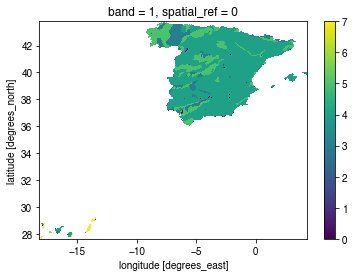

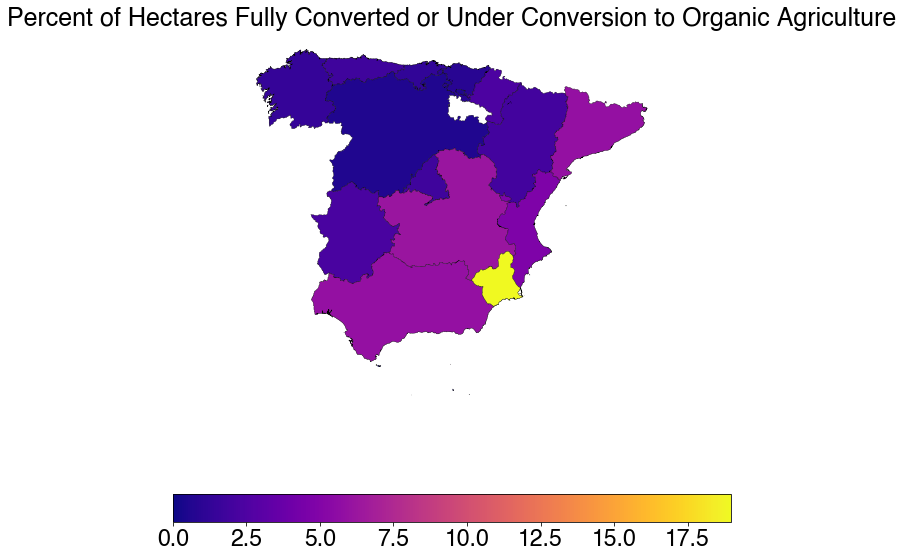

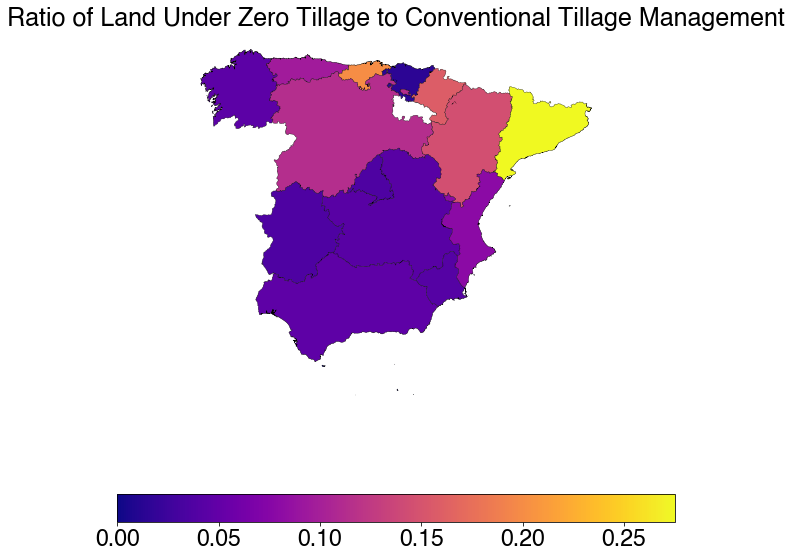

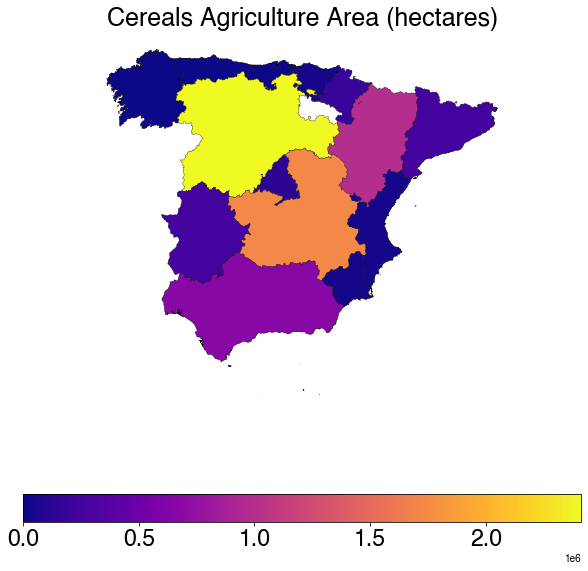

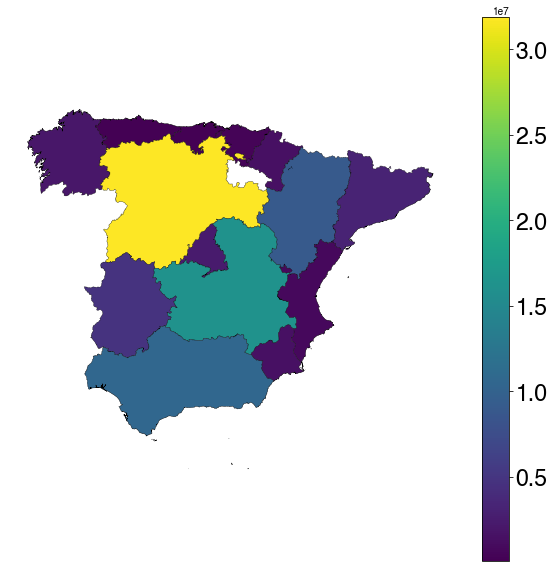

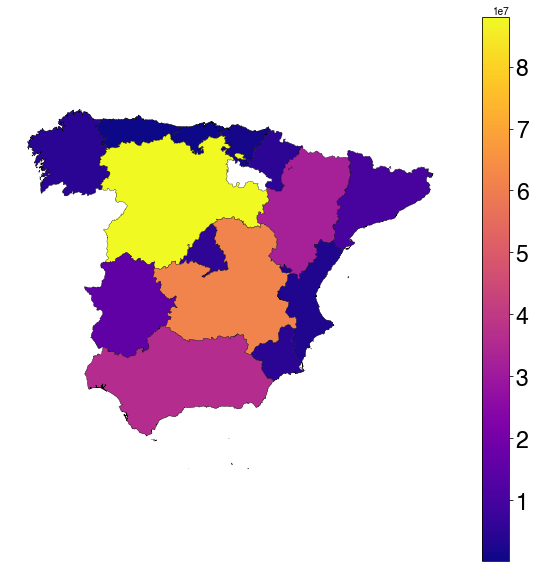

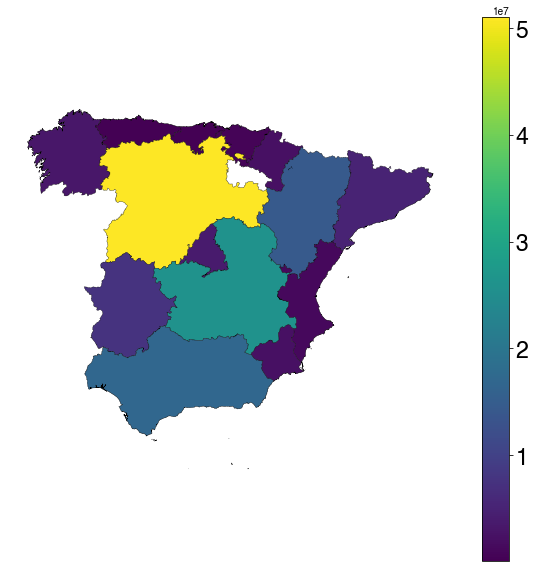

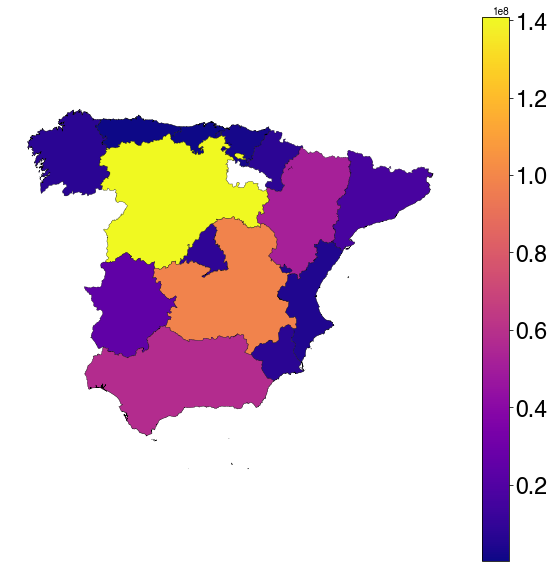

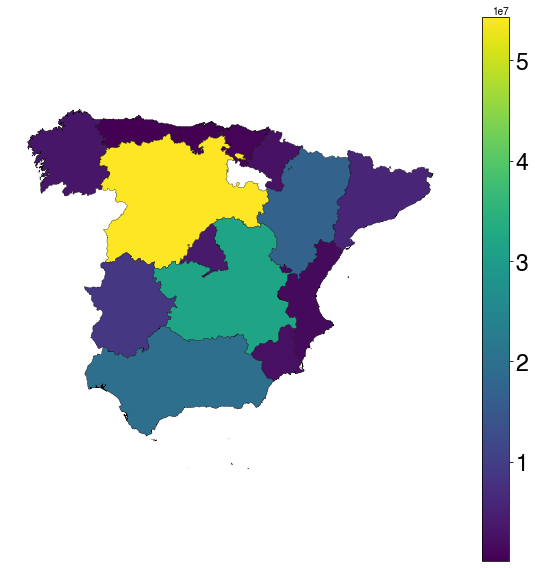

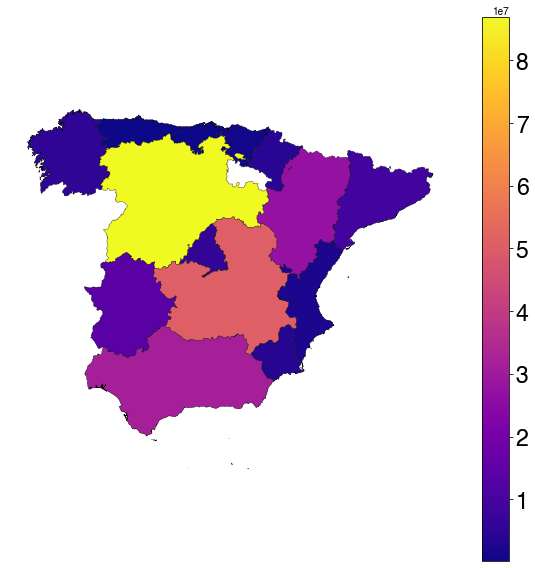

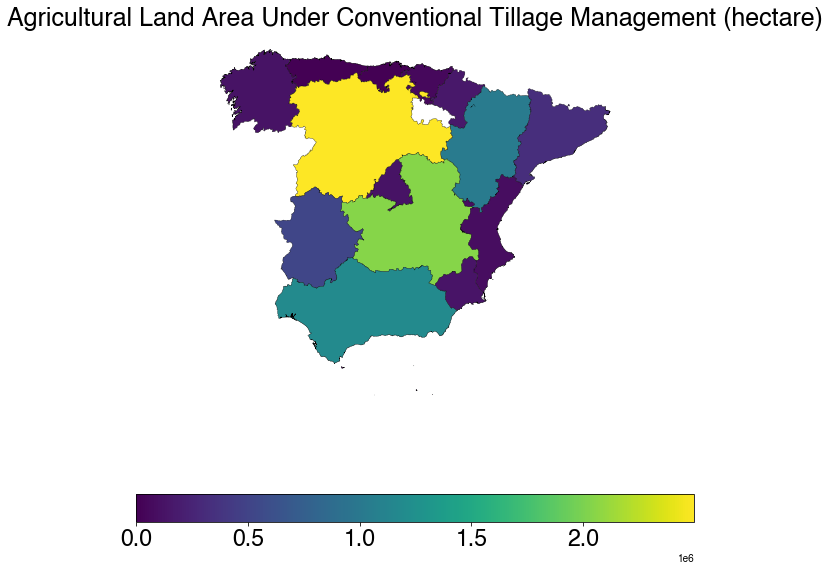

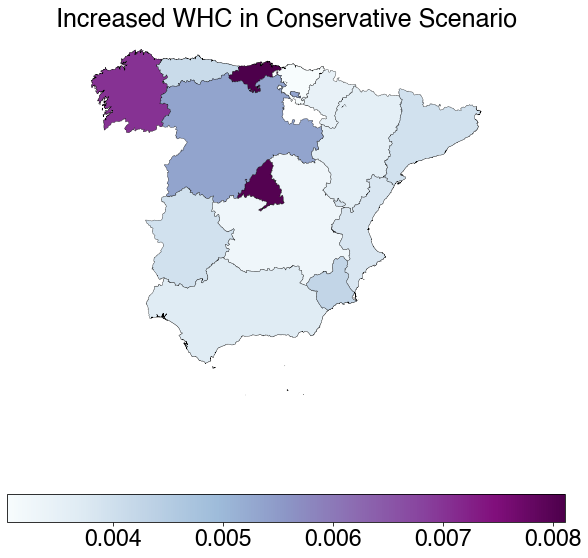

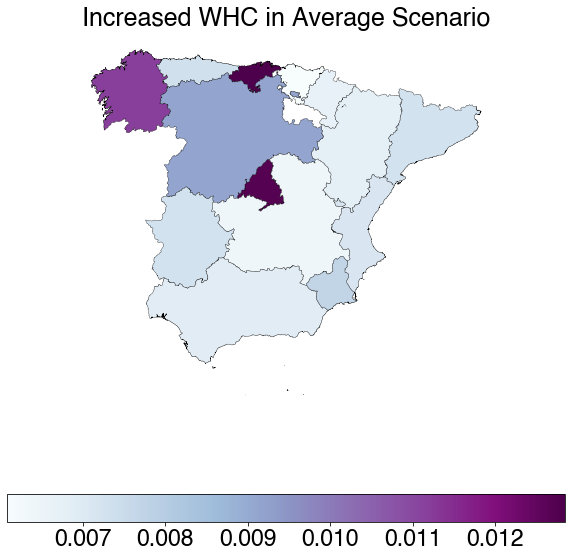

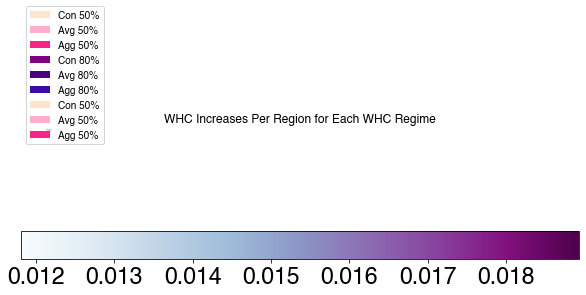

In [8]:
# set default font for maps
plt.rcParams['font.family'] = 'Helvetica'

# whc raster
whc_clipped.plot()
plt.savefig('whc_clipped.png')

# organic percentage figure
ax = spain_gdf_stat.plot(figsize=(10, 10), column='percent org area', edgecolor='k', linewidth = 0.3, cmap='plasma', legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Percent of Hectares Fully Converted or Under Conversion to Organic Agriculture",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_org_area.png')

# zero tillage ratio figure
ax = spain_gdf_stat.plot(figsize=(10, 10), column='tillage ratio', edgecolor='k', linewidth = 0.3, cmap='plasma', legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Ratio of Land Under Zero Tillage to Conventional Tillage Management",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_till_ratio.png')

# cereal agriculture area figure
ax = spain_gdf_stat.plot(figsize=(10, 10), column='ag area cereal', edgecolor='k', linewidth = 0.3, cmap='plasma', legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Cereals Agriculture Area (hectares)",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_cereal_area.png')

# potential soil water volume figures
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 50perc low pv', edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_50low.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 50perc high pv', edgecolor='k', linewidth = 0.3, cmap='plasma',legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_50high.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 80perc low pv', edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_80low.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 80perc high pv', edgecolor='k', linewidth = 0.3, cmap='plasma', legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_80high.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 50perc med pv', edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_50med.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc inc 80perc med pv', edgecolor='k', linewidth = 0.3, cmap='plasma', legend=True, legend_kwds={'orientation': "vertical"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_80med.png')

# conventional agriculture area figure
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='Conventional tillage', edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Agricultural Land Area Under Conventional Tillage Management (hectare)",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_conventional_area.png')

# whc difference figures (some figures may not populate in jupyter, see saved files!)
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc low no till diff', cmap = "BuPu", edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Increased WHC in Conservative Scenario",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_low_diff.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc med no till diff', cmap = "BuPu", edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Increased WHC in Average Scenario",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_med_diff.png')
ax = spain_gdf_stat_merge_diffs.plot(figsize=(10, 10), column='whc high no till diff', cmap = "BuPu", edgecolor='k', linewidth = 0.3, legend=True, legend_kwds={'orientation': "horizontal"}, missing_kwds={ "color": "lightgrey", "label": "Missing values"})
ax.set_title("Increased WHC in Aggressive Scenario",fontsize=25)
ax.set_axis_off()
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=23)
plt.savefig('Spain_high_diff.png')


# bar representation of potential soil water volume figures (will not populate in jupyter, see saved file!)
# get lists of regions potential for all scenarios
regions = spain_gdf_stat_merge_diffs['Regions'].to_list()
low50 = []
med50 = []
high50 = []
low80 = []
med80 = []
high80 = []
for i in regions:
    x1 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 50perc low pv'].sum()
    x2 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 50perc med pv'].sum()
    x3 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 50perc high pv'].sum()
    x4 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 80perc low pv'].sum()
    x5 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 80perc med pv'].sum()
    x6 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc inc 80perc high pv'].sum()
    low50.append(x1)
    med50.append(x2)
    high50.append(x3)
    low80.append(x4)
    med80.append(x5)
    high80.append(x6)

ind = np.arange(len(regions))
width = 1/7

#plot
plt.barh(ind, low50, width, label = 'Con 50%', linewidth = 0, color="#fde4cf")
plt.barh(ind + 1*width, med50, width, label = 'Avg 50%', linewidth = 0, color = '#ffafcc')
plt.barh(ind + 2*width, high50, width, label = 'Agg 50%', linewidth = 0, color = '#f72585')
plt.barh(ind + 3*width, low80, width, label = 'Con 80%', linewidth = 0, color = 'purple')
plt.barh(ind + 4*width, med80, width, label = 'Avg 80%', linewidth = 0, color = 'indigo')
plt.barh(ind + 5*width, high80, width, label = 'Agg 80%', linewidth = 0, color = '#3a0ca3')
  
plt.yticks(ind + 2*width, regions)
plt.xlabel("Cubic meters of Water")
plt.ylabel("Regions")
plt.title("Soil Water Holding Increases Per Region for Each Scenario")
plt.legend()
plt.savefig('Spain_regions_increase.png')


# bar representation of whc difference figures (will not populate in jupyter, see saved file!)
# get lists of regions potential for all scenarios
low_whc = []
med_whc = []
high_whc = []
for i in regions:
    x1 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc low no till diff'].sum()
    x2 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc med no till diff'].sum()
    x3 = spain_gdf_stat_merge_diffs[spain_gdf_stat_merge_diffs['Regions'] == i]['whc high no till diff'].sum()
    low_whc.append(x1)
    med_whc.append(x2)
    high_whc.append(x3)

ind = np.arange(len(regions))
width = 1/3

plt.barh(ind, low_whc, width, label = 'Con 50%', linewidth = 0, color="#fde4cf")
plt.barh(ind + 1*width, med_whc, width, label = 'Avg 50%', linewidth = 0, color = '#ffafcc')
plt.barh(ind + 2*width, high_whc, width, label = 'Agg 50%', linewidth = 0, color = '#f72585')

plt.yticks(ind + 2*width, regions)
plt.xlabel("mm of WHC")
plt.ylabel("Regions")
plt.title("WHC Increases Per Region for Each WHC Regime")
plt.legend()
plt.savefig('Spain_regions_diff.png')